In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import json
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random import choice
from time import time

In [611]:
df = pd.read_csv("datos_fotmob_completo.csv")
# Cambiamos los nombres de algunas variables, dropeamos los valores vacios y ordenamos por fecha
# La fecha va de la más antigua a la más nueva
df.rename(columns={'homeTeam_score': 'score_home',"awayTeam_score":"score_away"}, inplace=True)
df.rename(columns={'homeTeam': 'team_home',"awayTeam":"team_away"}, inplace=True)
df = df.sort_values(by="date",ignore_index=True)
df = df.drop(["discipline_away","discipline_home","duels_home","duels_away","defense_home","defense_away","shots_home","shots_away"], axis =1)
#Este dropeo es por mientras
df = df.drop(["accurate_passes_home","accurate_passes_away","long_balls_accurate_home","long_balls_accurate_away","accurate_crosses_home","accurate_crosses_away",
              "tackles_succeeded_home","tackles_succeeded_away","ground_duels_won_home","ground_duels_won_away","aerials_won_home","aerials_won_away",
              "dribbles_succeeded_home","dribbles_succeeded_away"], axis =1)
# Este dropeo hay que conversarlo
df.head()

,id,date,leagueName,team_home,team_away,score_home,score_away,homeIdTeam,awayIdTeam,parentLeagueId,...,expected_goals_home,expected_goals_away,expected_goals_open_play_home,expected_goals_open_play_away,expected_goals_set_play_home,expected_goals_set_play_away,expected_goals_non_penalty_home,expected_goals_non_penalty_away,expected_goals_on_target_home,expected_goals_on_target_away
0,1474723,2014-01-01,Premier League,Swansea City,Manchester City,2,3,10003,8456,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1475995,2014-01-01,League Two,Scunthorpe United,Rochdale,3,0,8412,8493,109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1474676,2014-01-01,Premier League,Arsenal,Cardiff City,2,0,9825,8344,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1474680,2014-01-01,Premier League,Crystal Palace,Norwich City,1,1,9826,9850,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1474689,2014-01-01,Premier League,Fulham,West Ham United,2,1,9879,8654,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [612]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475283 entries, 0 to 475282
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               475283 non-null  int64  
 1   date                             475283 non-null  object 
 2   leagueName                       475283 non-null  object 
 3   team_home                        475283 non-null  object 
 4   team_away                        475283 non-null  object 
 5   score_home                       475283 non-null  int64  
 6   score_away                       475283 non-null  int64  
 7   homeIdTeam                       475283 non-null  int64  
 8   awayIdTeam                       475283 non-null  int64  
 9   parentLeagueId                   473281 non-null  float64
 10  leagueId                         473281 non-null  float64
 11  BallPossesion_home               137910 non-null  float64
 12  Ba

In [613]:
# Estadisticas simples, ver si jugar en casa afecta
home_win = 0
away_win = 0
draw = 0

total = len(df)
home_win_percentage = sum(df["score_home"] > df["score_away"])/total
away_win_percentage = sum(df["score_home"] < df["score_away"])/total
draw_perentage = sum(df["score_home"] == df["score_away"])/total

In [614]:
print(home_win_percentage)
print(away_win_percentage)
print(draw_perentage)

0.4343096639265448
0.2995646804114601
0.2661256556619951


In [626]:
def get_features(data, side):
    if side == "home":
        return data[5:59].values
    elif side == "away": 
        original_lista = data.keys()[5:59]
        nueva_lista = [item.replace('home', 'temp').replace('away', 'home').replace('temp', 'away') for item in original_lista]
        return data.get(nueva_lista).values

# Esta funcion esta optimizada para funcionar con JobLib en paralelo
# Puesto que así es mucho más rápido.
def search_features(i, df, last_games):
    # W = home_win, D = draw, L = home_lose
    team_home = df.iloc[i]["team_home"]
    team_away = df.iloc[i]["team_away"]
    home_search = last_games
    away_search = last_games
    # W = win, D = draw, L = lose
    info_home = []
    info_away = []
    info_features_home = []
    info_features_away = []
    # Para hacer la busqueda más eficiente, solo buscamos en los partidos que estos equipos juegan
    df_match1 = df[df["team_home"] == team_home]
    df_match2 = df[df["team_away"] == team_home]
    df_match3 = df[df["team_home"] == team_away]
    df_match4 = df[df["team_away"] == team_away]
    df_match_index = sorted(list(set(df_match1.index) | set(df_match2.index) | set(
        df_match3.index) | set(df_match4.index)), reverse=True)
    # iteramos solo en los 
    for j in df_match_index:
        if away_search == 0 and home_search == 0:
            features_home_games = np.sum(info_features_home, axis=0)/last_games
            features_away_games = np.sum(info_features_away, axis=0)/last_games
            if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
                result = "W"
            elif df.iloc[i]["score_home"] == df.iloc[i]["score_away"]:
                result = "D"
            elif df.iloc[i]["score_home"] < df.iloc[i]["score_away"]:
                result = "L"
            return info_home, info_away, result, i,features_home_games,features_away_games
        # Buscamos los partidos anteriores del equipo de CASA
        # Como i es el partido actual y j el que estamos buscando,
        # si  i<j, entonces estamos en un partido del futuro (por lo que queremos lo contrario)
        if home_search > 0 and i-j > 0:
            if team_home == df.iloc[j]["team_home"]:
                info_features_home.append(
                        get_features(df.iloc[j], side="home"))
                home_search -= 1
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    info_home.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    info_home.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    info_home.append("D")
            elif team_home == df.iloc[j]["team_away"]:
                info_features_home.append(
                    get_features(df.iloc[j], side="away"))
                home_search -= 1
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    info_home.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    info_home.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    info_home.append("D")

        # Buscamos los partidos anteriores del equipo de VISITA
        if away_search > 0 and i-j > 0:
            if team_away == df.iloc[j]["team_home"]:
                info_features_away.append(
                    get_features(df.iloc[j], side="home"))
                away_search -= 1
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    info_away.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    info_away.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    info_away.append("D")
            elif team_away == df.iloc[j]["team_away"]:
                info_features_away.append(
                    get_features(df.iloc[j], side="away"))
                away_search -= 1
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    info_away.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    info_away.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    info_away.append("D")

In [650]:
# Pruebas de dataframe
df_test = df[df["red_cards_away"].notnull()].reset_index(drop=True)
lista_de_testeo= list(df_test.index)
df_test


,id,date,leagueName,team_home,team_away,score_home,score_away,homeIdTeam,awayIdTeam,parentLeagueId,...,expected_goals_home,expected_goals_away,expected_goals_open_play_home,expected_goals_open_play_away,expected_goals_set_play_home,expected_goals_set_play_away,expected_goals_non_penalty_home,expected_goals_non_penalty_away,expected_goals_on_target_home,expected_goals_on_target_away
0,1636598,2014-01-26,FA Cup,Chelsea,Stoke City,1,0,8455,10194,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1473211,2014-02-02,Eredivisie,RKC Waalwijk,PSV Eindhoven,2,0,10219,8640,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1474970,2014-02-11,Premier League,Hull City,Southampton,0,1,8667,8466,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1627329,2014-02-19,Copa Libertadores Grp. 5,Defensor Sporting,Cusco FC,4,1,7796,305171,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1473240,2014-02-22,Eredivisie,Cambuur,Roda JC Kerkrade,1,0,7788,9803,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92714,4203029,2024-02-06,League One,Port Vale,Leyton Orient,0,1,9799,8351,108.0,...,0.32,1.69,0.26,1.59,0.05,0.10,0.32,1.69,0.27,2.46
92715,4238239,2024-02-07,3. Liga,Unterhaching,Hallescher FC,2,0,8486,7761,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92716,4221121,2024-02-14,Premiership,Rangers,Ross County,3,1,8548,8649,64.0,...,4.91,0.54,4.34,0.45,0.57,0.09,4.91,0.54,5.27,0.84
92717,4221124,2024-02-14,Premiership,Aberdeen,Motherwell,3,3,8485,9927,64.0,...,1.42,2.56,0.73,1.69,0.69,0.08,1.42,1.77,1.99,3.61


In [655]:
# Last games = Juegos pasados a tener en cuenta
# Num_trabajadores = Trabajadores en paralelo (usar -1 para todos los posibles)
# Se demora un par de minutos
last_games = 15
num_trabajadores = -1
resultados = Parallel(n_jobs=num_trabajadores,verbose=10)(
    delayed(search_features)(i,df_test.head(i+1), last_games) for i in lista_de_testeo[40000:])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

KeyboardInterrupt: 

In [488]:
# X = Input Features
# Y = Outputs
# Index = Para identificar donde están en el dataframe original

# Los valores de X son tal que :
# [home_wins, home_draws, home_lose,
# away_wins, away_draws, away_lose,
# *[home_match1_win/lose/draw],*[home_match2_win/lose/draw],...*[home_matchN_win/lose/draw],
# *[away_match1_win/lose/draw],*[away_match2_win/lose/draw],...*[away_matchN_win/lose/draw]]
# Donde 
# *[XXX_match1_win/lose/draw] = *[1,0,0] = win
# *[XXX_match1_win/lose/draw] = *[0,1,0] = draw
# *[XXX_match1_win/lose/draw] = *[0,0,1] = lose
X = []
Y = []
index = []
for i in range(len(resultados)):
    if resultados[i] != None:
        index.append(resultados[i][3])
        
        streak_home = resultados[i][0]
        streak_away = resultados[i][1]
        result = resultados[i][2]

        # Suma de resultados

        home_wins = streak_home.count("W")
        home_draws = streak_home.count("D")
        home_lose = streak_home.count("L")

        away_wins = streak_away.count("W")
        away_draws = streak_away.count("D")
        away_lose = streak_away.count("L")

        features =[home_wins, home_draws, home_lose,
                  away_wins, away_draws, away_lose]

        # Con factor temporal
        # features = []
        for match in streak_home:
            if match == "W":
                features.extend([1,0,0])
            elif match == "D":
                features.extend([0,1,0])
            elif match == "L":
                features.extend([0,0,1])

        for match in streak_away:
            if match == "W":
                features.extend([1,0,0])
            elif match == "D":
                features.extend([0,1,0])
            elif match == "L":
                features.extend([0,0,1])

        X.append(features)

        if result == "W":
            Y.append([1, 0, 0])
        elif result == "D":
            Y.append([0, 1, 0])
        elif result == "L":
            Y.append([0, 0, 1])



In [197]:
import random
from copy import deepcopy
# Pruebas con random, para ver si esta todo bien
copy_X = deepcopy(X)
random.shuffle(copy_X)
copy_Y = deepcopy(Y)
random.shuffle(copy_Y)

In [361]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X, Y, index, test_size=0.2)

drop = 0.5
model = model = models.Sequential()
model.add(layers.InputLayer(input_shape=(len(X[0]),)))
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dropout(drop))
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dropout(drop))
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dropout(drop))
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dropout(drop))
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dense(64, activation='relu'),)
model.add(layers.Dense(3, activation='softmax'))
# # Compilamos el modelo
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer="adam", metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=100,
                    validation_data=(X_test, y_test))
print("hola")

Epoch 1/1000
9155/9155 [==============================] - 43s 5ms/step - loss: 1.0523 - categorical_accuracy: 0.4616 - val_loss: 1.0648 - val_categorical_accuracy: 0.4395
Epoch 2/1000
9155/9155 [==============================] - 13s 1ms/step - loss: 1.0472 - categorical_accuracy: 0.4663 - val_loss: 1.0701 - val_categorical_accuracy: 0.4323
Epoch 3/1000
9155/9155 [==============================] - 12s 1ms/step - loss: 1.0455 - categorical_accuracy: 0.4677 - val_loss: 1.0621 - val_categorical_accuracy: 0.4414
Epoch 4/1000
9155/9155 [==============================] - 13s 1ms/step - loss: 1.0446 - categorical_accuracy: 0.4678 - val_loss: 1.0525 - val_categorical_accuracy: 0.4623
Epoch 5/1000
9155/9155 [==============================] - 13s 1ms/step - loss: 1.0448 - categorical_accuracy: 0.4676 - val_loss: 1.0474 - val_categorical_accuracy: 0.4608
Epoch 6/1000
9155/9155 [==============================] - 13s 1ms/step - loss: 1.0443 - categorical_accuracy: 0.4677 - val_loss: 1.0451 - val_cat

KeyboardInterrupt: 

2289/2289 [==============================] - 1s 477us/step
Matriz de Confusión:


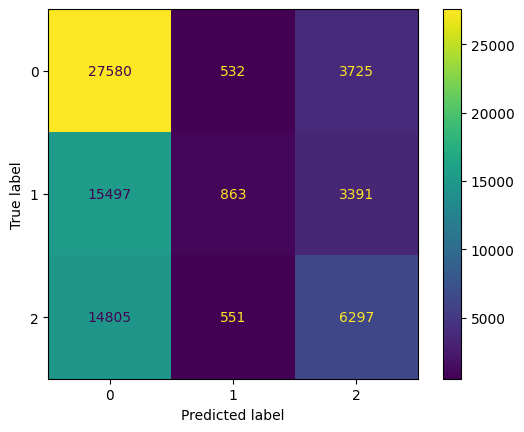

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


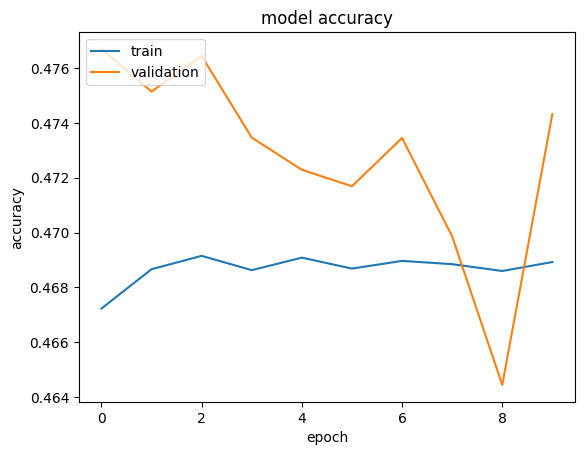

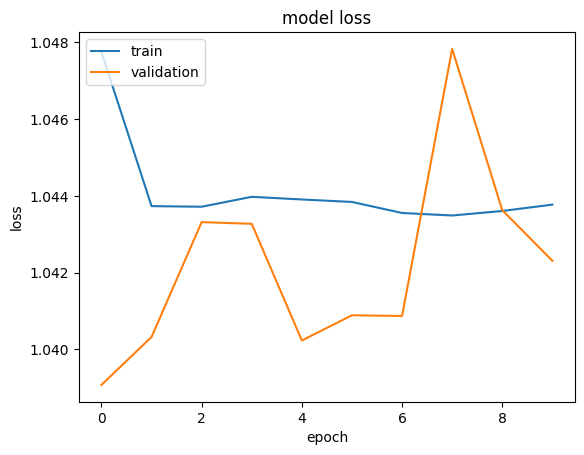

In [359]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
y_prob = model.predict(X_test)
y_test_metrics = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
print('Matriz de Confusión:')
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [203]:
print(classification_report(y_test_metrics, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6538
           1       0.91      0.92      0.92      3422
           2       0.96      0.92      0.94      4639

    accuracy                           0.94     14599
   macro avg       0.94      0.93      0.93     14599
weighted avg       0.94      0.94      0.94     14599

